In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


### Display Function

In [2]:
def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
def crop_barcode(img):
    # Find contours in the binary image
    contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Find the horizontal limits of the barcode
    x_min = min([cv.boundingRect(contour)[0] for contour in contours])  # Leftmost x-coordinate
    x_max = max([cv.boundingRect(contour)[0] + cv.boundingRect(contour)[2] for contour in contours])  # Rightmost x-coordinate

    # Assume the largest contour corresponds to the vertical extent of the barcode
    largest_contour = max(contours, key=cv.contourArea)
    _, y, _, h = cv.boundingRect(largest_contour)  # Get the y and height (vertical cropping)

    # Crop the image so that only the barcode is visible
    cropped_img = img[y:y + h, x_min:x_max]
    
    # Draw the bounding rectangle of the largest contour in green
    cv.rectangle(img, (x_min, y), (x_max, y + h), (0, 255, 0), 2)

    # Draw all contours in red
    contour_img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
    cv.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Draw all contours in red

    return cropped_img, contour_img


In [4]:
def crop_barcode2(img):

    # Find contours in the binary image
    contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour probably corresponds to a wide bar in the barcode
    largest_contour = max(contours, key=cv.contourArea)
    largest_contour_area = cv.contourArea(largest_contour)

    # Find the horizontal limits of the barcode
    x_min = None
    x_max = None
    for contour in contours:
        contour_area = cv.contourArea(contour)
        if contour_area >= 0.2 * largest_contour_area:  # Check if the contour area is at least 20% of the largest contour
            x, _, w, _ = cv.boundingRect(contour)
            if x_min is None or x < x_min:
                x_min = x
            if x_max is None or x + w > x_max:
                x_max = x + w

    # If no valid contours are found, use the entire width of the image
    if x_min is None or x_max is None:
        x_min = 0
        x_max = img.shape[1]

    # Get the vertical limits from the largest contour
    _, y, _, h = cv.boundingRect(largest_contour)

    # Crop the image so that only the barcode is visible
    cropped_img = img[y:y + h, x_min:x_max]

    # Draw the bounding rectangle of the largest contour in green
    cv.rectangle(img, (x_min, y), (x_max, y + h), (0, 255, 0), 2)

    # Draw all contours in red
    contour_img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
    cv.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Draw all contours in red

    return cropped_img, contour_img

### Read image

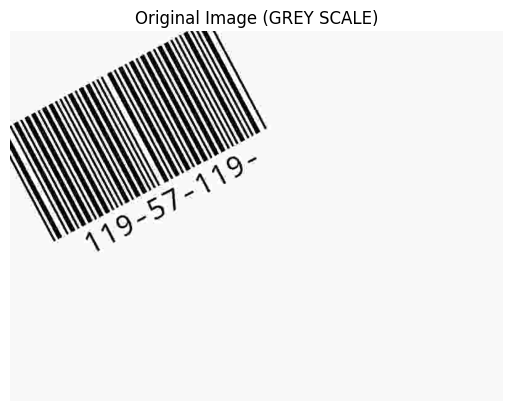

In [5]:
img = cv.imread('09 - e3del el soora ya3ammm.jpg', cv.IMREAD_GRAYSCALE)
display_image(img,'Original Image (GREY SCALE)')

### Applying Median Bluring

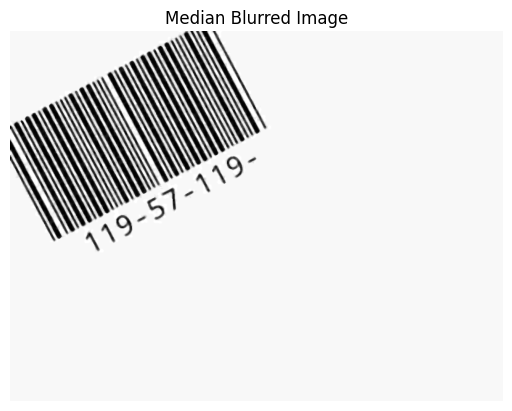

In [6]:
blurred_img = cv.medianBlur(img, 5)
display_image(blurred_img, 'Median Blurred Image')

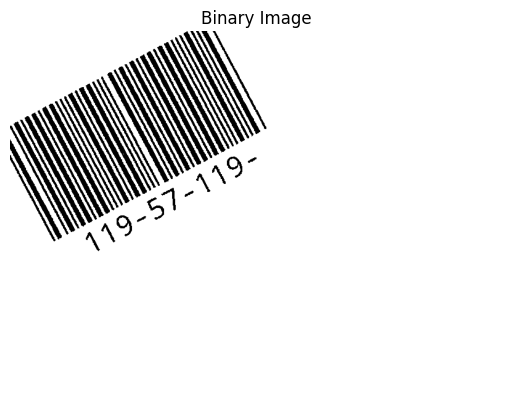

In [7]:
_, binary_img = cv.threshold(img, 128, 255, cv.THRESH_BINARY)
display_image(binary_img, 'Binary Image')

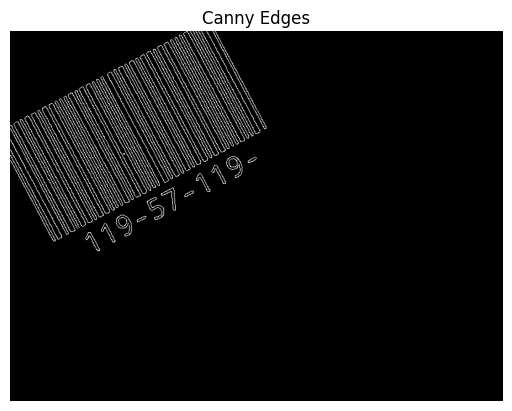

In [8]:
edges = cv.Canny(binary_img, 50, 200)
display_image(edges, 'Canny Edges')

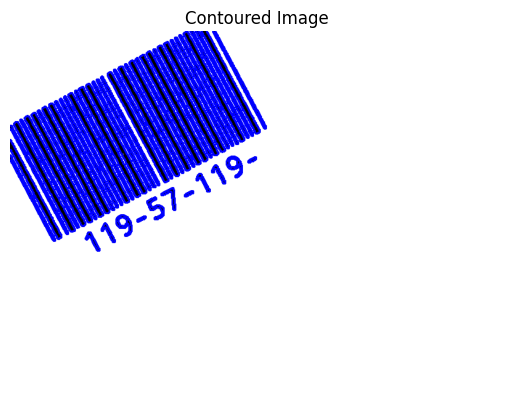

In [9]:
# Find contours in the binary image
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw all contours in red on a copy of the original image
contour_img = cv.cvtColor(binary_img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
cv.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Draw all contours in red

# Display the contoured image
display_image(contour_img, 'Contoured Image')

In [10]:
largest_contour = max(contours, key=cv.contourArea)
print("Largest Contour Area:", cv.contourArea(largest_contour))

Largest Contour Area: 1568.5


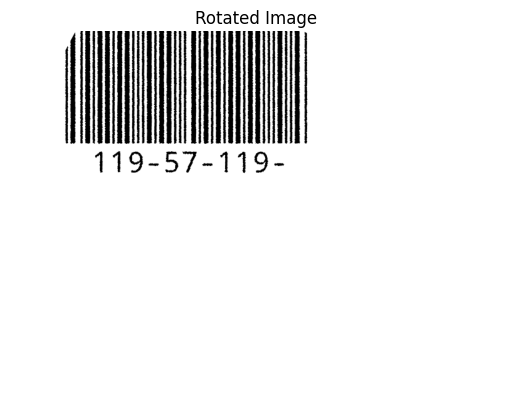

In [11]:
# Find the minimum area rectangle for the largest contour
rect = cv.minAreaRect(largest_contour)
angle = rect[-1]

# Adjust the angle
if angle < -90:
    angle = -(90+angle)
else:
    angle = -angle
    
r_angle = 90 - angle    

# Rotate the image to make the barcode 90 degrees
(h, w) = binary_img.shape[:2]
center = (w // 2, h // 2)
M = cv.getRotationMatrix2D(center, r_angle, -1.0)
rotated_img = cv.warpAffine(binary_img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT, borderValue=(255, 255, 255))

# Display the rotated image
display_image(rotated_img, 'Rotated Image')

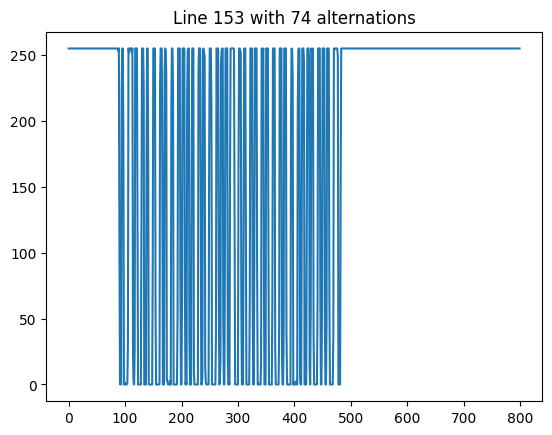

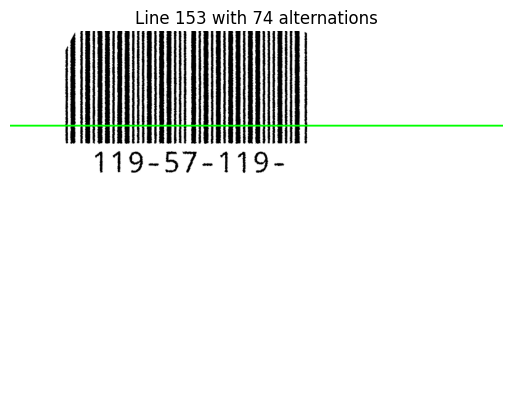

In [12]:
def count_alternations(line):
    alternations = 0
    current_color = line[0]
    for pixel in line:
        if pixel != current_color:
            alternations += 1
            current_color = pixel
    return alternations

# Find the line with the most alternations
max_alternations = 0
line_index = 0
for i in range(rotated_img.shape[0]):
    line = binary_img[i, :]
    alternations = count_alternations(line)
    if alternations > max_alternations:
        max_alternations = alternations
        line_index = i

# Plot the line with the most alternations
plt.plot(rotated_img[line_index, :])
plt.title(f'Line {line_index} with {max_alternations} alternations')
plt.show()
# Plot the line on the image
line_img_copy = cv.cvtColor(rotated_img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
cv.line(line_img_copy, (0, line_index), (rotated_img.shape[1], line_index), (0, 255, 0), 2)  # Draw the line in green

# Display the image with the line
display_image(line_img_copy, f'Line {line_index} with {max_alternations} alternations')

Longest black column is at index 125 with length 182


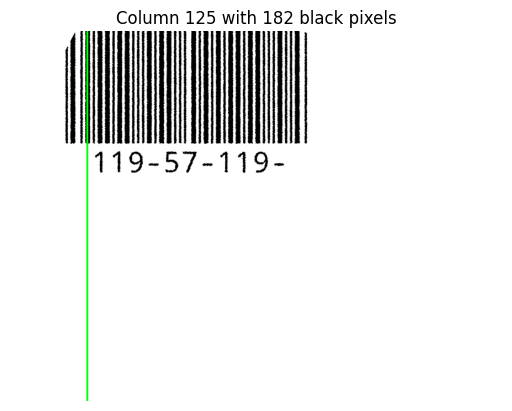

In [13]:
def find_longest_black_column(binary_img):
    max_length = 0
    max_col_index = 0

    for col in range(binary_img.shape[1]):
        current_length = 0
        max_current_length = 0

        for row in range(binary_img.shape[0]):
            if binary_img[row, col] == 0:
                current_length += 1
                if current_length > max_current_length:
                    max_current_length = current_length
            else:
                current_length = 0

        if max_current_length > max_length:
            max_length = max_current_length
            max_col_index = col

    return max_col_index, max_length

# Find the longest black column
col_index, col_length = find_longest_black_column(rotated_img)
print(f'Longest black column is at index {col_index} with length {col_length}')

# Plot the column on the image
column_img_copy = cv.cvtColor(rotated_img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
cv.line(column_img_copy, (col_index, 0), (col_index, rotated_img.shape[0]), (0, 255, 0), 2)  # Draw the column in green

# Display the image with the column
display_image(column_img_copy, f'Column {col_index} with {col_length} black pixels')

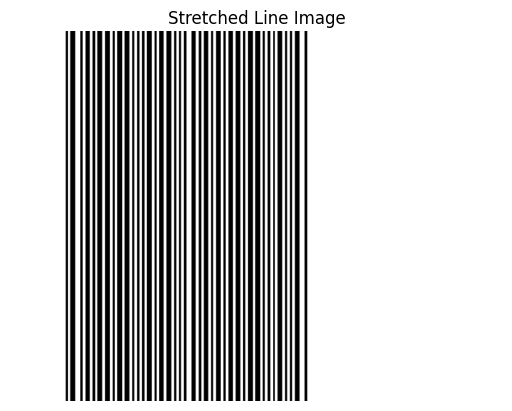

In [14]:
# Extract the best line
best_line = rotated_img[line_index, :]

# Create an empty image with the same width and height as the original image
stretched_line_img = np.zeros_like(rotated_img)

# Stretch the best line vertically to fill the image
for i in range(stretched_line_img.shape[0]):
    stretched_line_img[i, :] = best_line

# Display the stretched line image
display_image(stretched_line_img, 'Stretched Line Image')

In [15]:
_,max_length=find_longest_black_column(rotated_img)

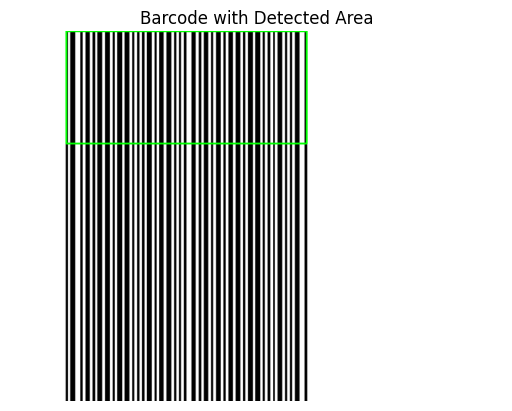

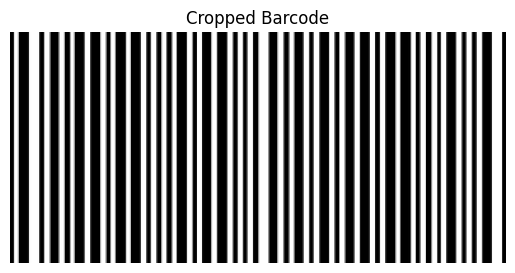

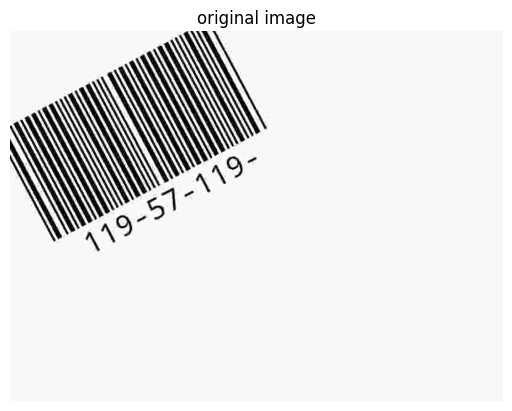

In [16]:
def calculate_barcode_area(binary_img, stretched_line, line_index):
    # Find x-coordinates of the barcode in the best line
    black_regions = np.where(stretched_line == 0)[0]  # Indices where the pixel is black
    x_min = black_regions.min()
    x_max = black_regions.max()

    # Find y-coordinates (vertical limits) in the original binary image
    contours, _ = cv.findContours(stretched_line_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv.contourArea)
    y_min, y_max = cv.boundingRect(largest_contour)[1], max_length

    # Crop the original barcode area
    cropped_barcode = stretched_line_img[y_min:y_max, x_min:x_max]

    # Draw a rectangle around the detected barcode area
    contour_img = cv.cvtColor(stretched_line_img, cv.COLOR_GRAY2BGR)
    cv.rectangle(contour_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    return cropped_barcode, contour_img

# Calculate the barcode area
cropped_barcode, barcode_with_rectangle = calculate_barcode_area(stretched_line_img, best_line, line_index)

# Display the results
display_image(barcode_with_rectangle, "Barcode with Detected Area")
display_image(cropped_barcode, "Cropped Barcode")
display_image(img , "original image")
